In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio

In [2]:
from scipy.ndimage import rotate

In [3]:
import matplotlib.pyplot as plt

In [4]:
from PIL import Image as im

In [83]:
import glob

In [141]:
from skimage.transform import resize

In [28]:
import math

### Constants (code omitted in webpage submission)

In [5]:
COLOR_LETTER_TO_INDEX = {'b':2, 'g':1, 'r':0}

### Defining helper functions (code omitted in webpage submission)

In [6]:
def read_img(name):
    # read in the image
    im = skio.imread(name)

    # convert to double (might want to do this later on to save memory)    
    im = sk.img_as_float(im)

    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(np.int)
    
    im_channels = {}
    # separate color channels
    
    im_channels['b'] = im[:height]
    im_channels['g'] = im[height: 2*height]
    im_channels['r'] = im[2*height: 3*height]
    
    return im_channels


In [82]:
def display_dictionary_of_images(dic, prefix, horiz = False, w = 6, h = 5):
    %matplotlib inline
    
    if horiz:
    
        fig = plt.figure(figsize=(w * len(dic), h))
        try:
            subplots = list(fig.subplots(1, len(dic)))
        except:
            subplots = [fig.subplots(1, len(dic))]
    else:
        fig = plt.figure(figsize=(w, h * len(dic)))
        try:
            subplots = list(fig.subplots(len(dic), 1))
        except:
            subplots = [fig.subplots(len(dic), 1)]
    
    keylist = list(dic.keys())
    
    for i in range(len(dic)):
        key = keylist[i]      
        pixels = dic[key]

        #Display the image
        ax = subplots[i]
        ax.set_title(prefix + ' ' + key)
        if len(pixels.shape) == 2:
            # grayscale (scalars)
            ax.imshow(pixels,cmap='Greys_r', vmin=0, vmax=1)
        if len(pixels.shape) == 3:
            # rgb
            ax.imshow(pixels)
            
"""
array of images is a list within a list
array of names is too
"""
def display_grid_of_images(array_of_images, array_of_names, w = 6, h = 5):
    num_rows = len(array_of_images)
    num_cols = len(array_of_images[0])
    
    assert len(array_of_names) == num_rows, "same num of rows for names and images"
    
    assert all([len(row) == num_cols for row in array_of_images]), "all rows need to be same length"
    assert all([len(row) == num_cols for row in array_of_names]), "all rows need to be same length for strings too"
    
    fig = plt.figure(figsize=(w * num_cols, h * num_rows))
    subplots = fig.subplots(num_rows, num_cols)
    
    for row in range(num_rows):
        for col in range(num_cols):
            
            ax = subplots[row, col]
            ax.set_title(array_of_names[row][col])
            pixels = array_of_images[row][col]
            
            if len(pixels.shape) == 2:
                # grayscale (scalars)
                ax.imshow(pixels,cmap='Greys_r', vmin=0, vmax=1)
            if len(pixels.shape) == 3:
                # rgb
                ax.imshow(pixels)
            
    

In [8]:
def convert_to_color(x, index):
    blank = np.zeros(x.shape)
    res = np.stack(([blank]*index) + [x] + ([blank]* (2 - index)), axis = 2)
    return res


In [11]:
def convert_to_three_colors(dic):
    keys = dic.keys()
    vals = [convert_to_color(dic[key], COLOR_LETTER_TO_INDEX[key]) for key in keys]
    return dict(zip(keys, vals))

In [14]:
"""
dic schema:
{
    'b': array for b
    'g': array for g
    'r': array for r
}
offset schema:
    [
    [green x offset, green y offset, green angle],
    [red x offset, red y offset, red angle]
    ]

"""
def create_offset(dic, offset, red = True, green = True):
    res = {'b': dic['b']}
    
    if green:
        new_g = dic['g']
        # roll green x axis
        new_g = np.roll(new_g, offset[0][0], axis=1)
        # roll green y axis
        new_g = np.roll(new_g, offset[0][1], axis=0)
        # rotate green
        new_g = rotate(new_g, offset[0][2], reshape = False)
        # save green
        res['g'] = new_g
    if red:
        new_r = dic['r']
        # roll red x axis
        new_r = np.roll(new_r, offset[1][0], axis=1)
        # roll red y axis
        new_r = np.roll(new_r, offset[1][1], axis=0)
        # rotate red
        new_r = rotate(new_r, offset[1][2], reshape = False)
        # save red
        res['r'] = new_r
    
    return res
    

In [15]:
stack_dict = lambda dic: np.sum(list(dic.values()), axis = 0)

In [119]:
def simple_score(blue, other):
    def ssd(a, b):
        return -np.sum((a-b)**2)
    assert(len(blue.shape) == len(other.shape)) and (len(blue.shape) == 2), "images must both be 2d"
    xmin, xmax = int(blue.shape[1]*0.2), int(blue.shape[1]*0.8)
    ymin, ymax = int(blue.shape[0]*0.2), int(blue.shape[0]*0.8)
    blue_compare_sample = blue[ymin:ymax, xmin:xmax]
    other_compare_sample = other[ymin:ymax, xmin:xmax]
    
    return ssd(blue_compare_sample, other_compare_sample)



In [158]:
"""
start_dict: self explanatory
score: score function to judge each offset. higher is better
center_x: default should be zero. center point for the offsets being tested
center_y: default should be zero. center point for the offsets being tested
move_max: the largest offset away from the center that will be tested
center_angle: center point for the angles being tested
angle_max: the largest offset away from center angle that will be tested
num_checks: the number of different values to be tested for the offset of each dimension


returns:
best_offset:
    [[best green x, best green y, best green angle],
    [best red x, best red y, best red angle]]
    
"""
def get_best(start_dict, score, center_x, center_y, move_max, center_angle, angle_max, num_checks_move, num_checks_angle, verbose = True, scale = 1):
    best_offset = []
    start_dict = scale_down(start_dict, scale)
    for color in ['g', 'r']:
        verbose and print(f"starting with color {color}. ", end = '')
        verbose and print("x delta: ", end='')
        best_offset_score = float('-inf')
        for x_delta_unscaled in np.linspace(center_x[color] - move_max, center_x[color] + move_max, num_checks_move, True).astype(int):
            verbose and print(f"{x_delta_unscaled}, ", end='')
            for y_delta_unscaled in np.linspace(center_y[color] - move_max, center_y[color] + move_max, num_checks_move, True).astype(int):
                for theta in np.linspace(center_angle[color] - angle_max, center_angle[color] + angle_max, num_checks_angle, True).astype(int):
                    x_delta = x_delta_unscaled // scale
                    y_delta = y_delta_unscaled // scale
                    if color == 'g':
                        test_offset = [[x_delta, y_delta, theta],[0,0,0]]
                    else:
                        test_offset = [[0,0,0],[x_delta, y_delta, theta]]
                    test_dic = create_offset(start_dict, test_offset, \
                                             red = (color == 'r'),\
                                             green = (color == 'g'))
                    curr_offset_score = score(test_dic['b'], test_dic[color])
                    if curr_offset_score > best_offset_score:
                        best_offset_score = curr_offset_score
                        best_offset_arg = [x_delta_unscaled, y_delta_unscaled, theta]
        verbose and print("")
        best_offset.append(best_offset_arg)
    return best_offset
    
def scale_down(start_dict, scale):
    res = {}
    for key in start_dict.keys():
        img = start_dict[key]
        width = int(img.shape[1] / scale)
        height = int(img.shape[0] / scale)
        dim = (height, width)
        resized = resize(img, dim)
        res[key] = resized
    return res



In [169]:
def pyramid_find_offset(start_dict, score, max_movement, min_movement, max_angle, verbose = True):
    # assert that movement are power of 2, angle are power of 2 * 0.1
    assert int(math.log2(max_movement)) == math.log2(max_movement), "movement offset not power of 2"
    assert int(math.log2(max_angle * 10)) == math.log2(max_angle * 10), "movement offset not power of 2"
    
    curr_max_movement, curr_max_angle = max_movement, max_angle
    
    # it will start out checking the range of [0 - max_movement, 0 + max_angle]
    curr_middle_x = {
        'g': 0,
        'r': 0
    }
    curr_middle_y = {
        'g': 0,
        'r': 0
    }
    curr_middle_angle = {
        'g': 0,
        'r': 0
    }
    
    # Narrow down the movement first to get the best offset - angle comes later
    
    verbose or print("doing pyramid search with resolution of pixels:", end = '')
    while curr_max_movement > min_movement:
        
        # it will try 5 thing: the ends, middle, and 25th and 75th percentile of the range.
        
        # fix angle at 0 for now
        verbose or print(curr_max_movement/2, end = '  ')
        scale_down = curr_max_movement//2
        verbose and print(f"currently trying movements around {curr_middle_x['g']}, {curr_middle_y['g']} for g and {curr_middle_x['r']}, {curr_middle_y['r']} for r. ", end = '')
        verbose and print(f"current range is {curr_max_movement}")
        # run this function to get the best offset among the 5 * 5 * 1 that we are doing
        best_offset = get_best(start_dict, score, 
                               center_x = curr_middle_x, center_y = curr_middle_y, move_max = curr_max_movement,
                               center_angle = curr_middle_angle, angle_max = 0,
                               num_checks_move = 5, num_checks_angle= 1, 
                               verbose=False, scale = scale_down)
        
        curr_max_movement = curr_max_movement // 2
        curr_middle_x = {
            'g': best_offset[0][0],
            'r': best_offset[1][0]
        }
        curr_middle_y = {
            'g': best_offset[0][1],
            'r': best_offset[1][1]
        }
    verbose or print('')
    verbose and print(f"best movement offset is {curr_middle_x['g']}, {curr_middle_y['g']} for g and {curr_middle_x['r']}, {curr_middle_y['r']} for r.")
    verbose and print("now trying angles.")
    
    # Now, find the best angle
    verbose or print("doing pyramid search with resolution of degrees:", end = '')
    while curr_max_angle > 0.1:
        
        # do same as above but for angles. This time, movement is fixed.
        verbose or print(curr_max_angle/4, end = '  ')
        verbose and print(f"currently trying angles around {curr_middle_angle['g']} for g and {curr_middle_angle['r']} for r. ", end = '')
        verbose and print(f"current range is {curr_max_angle}")
        best_offset = get_best(start_dict, score, 
                               center_x = curr_middle_x, center_y = curr_middle_y, move_max = 0,
                               center_angle = curr_middle_angle, angle_max = curr_max_angle,
                               num_checks_move = 1, num_checks_angle= 9,
                              verbose=False)
        
        curr_max_angle = curr_max_angle / 2
        curr_middle_angle = {
            'g': best_offset[0][2],
            'r': best_offset[1][2]
        }
    verbose or print('')
    verbose and print(f"best angle offset is {curr_middle_angle['g']} for g and {curr_middle_angle['r']} for r.")
    verbose and print("done.")
    return [[curr_middle_x['g'], curr_middle_y['g'], curr_middle_angle['g']],
           [curr_middle_x['r'], curr_middle_y['r'], curr_middle_angle['r']]]
        
    

### Main body - not including EC (code omitted in webpage submission)

### Get list of image files

In [84]:
list_of_files = glob.glob("data/*")

In [86]:
for filename in list_of_files:
    file = skio.imread(filename)
    print(f"{filename} size: {file.shape}")

data\cathedral.jpg size: (1024, 390)
data\church.tif size: (9607, 3634)
data\emir.tif size: (9627, 3702)
data\harvesters.tif size: (9656, 3683)
data\icon.tif size: (9732, 3741)
data\lady.tif size: (9637, 3761)
data\melons.tif size: (9724, 3770)
data\monastery.jpg size: (1024, 391)
data\onion_church.tif size: (9646, 3781)
data\self_portrait.tif size: (9754, 3810)
data\three_generations.tif size: (9629, 3714)
data\tobolsk.jpg size: (1024, 396)
data\train.tif size: (9715, 3741)
data\workshop.tif size: (9627, 3741)


**The jpg files all have width between 300-400, and the tif all have width between 3000-4000**

### Do the reading, exhaustive search, and pyramid search for all the files

In [170]:
grid_of_images = []
grid_of_names = []
list_of_pyramid_offsets = []

for filename in list_of_files:
    name = filename[5:-4]
    
    # this will store each version of this image (no offset, exhaustive search offset, and pyramid search offset)
    this_img_versions = []
    # this will store the title of each of the versions above
    this_img_titles = []
    
    # read the image and split it
    initial_colors = read_img(filename)
    
    # Do one with no offset first
    no_offset_img = stack_dict(convert_to_three_colors(initial_colors))
    
    this_img_versions.append(no_offset_img)
    this_img_titles.append(f"{name}, no offset")
    
    # Do the simple exhaustive search
    
    if initial_colors['b'].shape[1] > 1000:
        print(f"{name} is a big file. skipping exhaustive search")
        this_img_versions.append(np.array([[0,0],[0,0]]))
        this_img_titles.append("exhaustive search skipped")
        
    else:
        print(f"starting exhaustive search +- 15 for {name}")

        # This is how to pass zero as the argument for the below function
        zero_for_both = {'g': 0, 'r': 0}
        exhaustive_search_offset = get_best(start_dict=initial_colors, score=simple_score, 
                                           center_x = zero_for_both, center_y = zero_for_both, move_max = 15, 
                                            center_angle = zero_for_both, angle_max = 0,
                                            num_checks_move = 31, num_checks_angle = 1, verbose = True)
        print(f"finished exhaustive search for {name}")

        exhaustive_search_offset_img = stack_dict(create_offset(convert_to_three_colors(initial_colors), exhaustive_search_offset))
        this_img_versions.append(exhaustive_search_offset_img)
        this_img_titles.append(f"{name}, exhaustive offset")
    
    # Do the pyramid search
    if initial_colors['b'].shape[1] > 1000:
        print("big file so pyramid search has max offset 256")
        max_offset = 64
        min_offset = 4
    else:
        print("small file so pyramid search has max offset 32")
        max_offset = 32
        min_offset = 2
        
    print(f"starting pyramid search for {name}")
    
    pyramid_search_offset = pyramid_find_offset(start_dict = initial_colors, score = simple_score, 
                                                   max_movement = max_offset, min_movement=min_offset,
                                                   max_angle = 0.8,
                                                   verbose = False)
    print(f"finished pyramid search for {name}")
    
    pyramid_search_offset_img = stack_dict(create_offset(convert_to_three_colors(initial_colors), pyramid_search_offset))
    this_img_versions.append(pyramid_search_offset_img)
    this_img_titles.append(f"{name}, pyramid offset")
    
    grid_of_images.append(this_img_versions)
    grid_of_names.append(this_img_titles)
    
    list_of_pyramid_offsets.append(pyramid_search_offset)

    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if __name__ == '__main__':


starting exhaustive search +- 15 for cathedral
starting with color g. x delta: -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
starting with color r. x delta: -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 
finished exhaustive search for cathedral
small file so pyramid search has max offset 32
starting pyramid search for cathedral
doing pyramid search with resolution of pixels:8.0  4.0  2.0  1.0  
doing pyramid search with resolution of degrees:0.2  0.1  
finished pyramid search for cathedral
church is a big file. skipping exhaustive search
big file so pyramid search has max offset 256
starting pyramid search for church
doing pyramid search with resolution of pixels:16.0  8.0  4.0  2.0  
doing pyramid search with resolution of degrees:0.2  0.1  
finished pyramid search for church
emir is a big file. skipping exhaustive search
big file so pyra

# Project 1 - Jerry Lai

## Methodology

- The images are split into the 3 color channels naively, as is done in the starter code.
- For the jpeg images, both the exhaustive search and pyramid search are used to find the best offset.
- For the tif images, only the pyramid search are used, because the exhaustive search was too computationally expensive.

### Exhaustive search

- The exhaustive search uses $\pm$ 15 pixels in each direction, for both green and red channels. Blue channel is fixed.
- The offset that provides the best score is returned.
- Function name - `get_best()`

### Pyramid search

- The pyramid search doubles the resolution in each pass. At each resolution, it reuses the exhaustive search function but only checks 9 offsets in each direction
    - For example if the resolution is 4, the $x$ center of the search is 0, then it will check [-16, -12, -8, -4,  0,4, 8,12, 16]. 
    - The resolution is controlled by the `max_movement` variable. It is always 4x resolution. In the above example, it is 16.
- At each iteration, the resolution is halved. It can be quartered, but in testing it resulted in fitting to local minima.
- At each iteration, the best offset in the previous iteration is used as the center.
- At each iteration, the image is resized so that the step size is always one pixel in the resized image


- A similar thing is done with angles - instead of moving, it is rotated.
    - This is done after the best offset for x and y are already known.
    

### Score function

- Score function is the negative of the SSD. Higher is better.
- I also experimented with cross correlation. However, after experimenting on jpgs, it usually returned the same offsets as SSD. So I went with SSD because it is simpler.

## Results

### Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

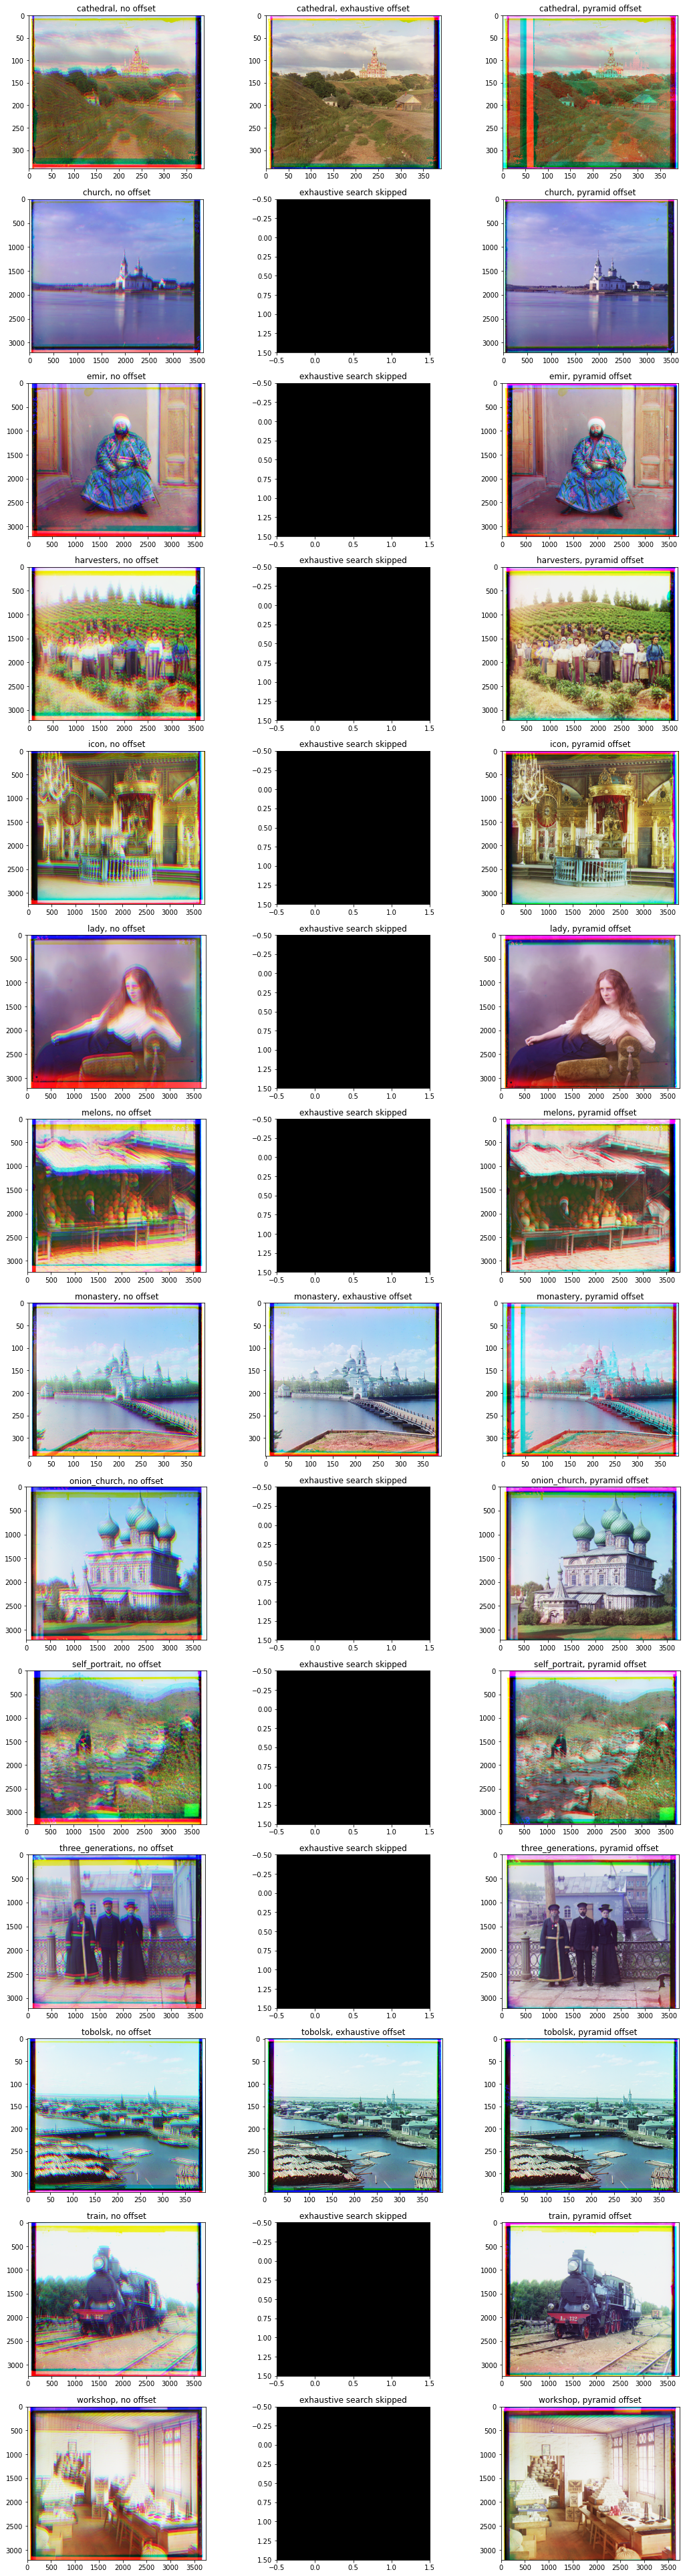

In [171]:
display_grid_of_images(grid_of_images, grid_of_names)

As seen above, the pyramid method works well for most of the images, however, in some of them, expecially ones with repeated patterns, it has found local minima.

### Offsets:

Offsets are of the format:

    [[best green x, best green y, best green angle],
    [best red x, best red y, best red angle]]


In [167]:
for i in range(len(list_of_files)):
    name = list_of_files[i]
    name = name[5:-4]
    print(f"{name} offset: {list_of_pyramid_offsets[i]}")

cathedral offset: [[60, 2, 0], [61, 8, 0]]
church offset: [[4, 24, 0], [248, 64, 0]]
emir offset: [[24, 48, 0], [44, 60, 0]]
harvesters offset: [[16, 60, 0], [16, 124, 0]]
icon offset: [[16, 40, 0], [24, 88, 0]]
lady offset: [[8, 56, 0], [12, 112, 0]]
melons offset: [[12, 84, 0], [16, 180, 0]]
monastery offset: [[2, -3, 0], [60, 5, 0]]
onion_church offset: [[28, 52, 0], [36, 108, 0]]
self_portrait offset: [[28, 76, 0], [36, 176, 0]]
three_generations offset: [[16, 52, 0], [12, 112, 0]]
tobolsk offset: [[3, 3, 0], [52, 10, 0]]
train offset: [[8, 44, 0], [32, 88, 0]]
workshop offset: [[0, 52, 0], [-12, 104, 0]]
